In [1]:
import sys

# make sure you are using `isochrones` environment
assert sys.executable.split('/')[5]=='isochrones'

In [2]:
# Inside this jupyter lab, do not use `pip install xxx`, instead use:
# import sys
# !{sys.executable} -m pip install xxx

In [3]:
# check if package is installed
!{sys.executable} -m pip show isochrones

Name: isochrones
Version: 2.1
Summary: Defines objects for interpolating stellar model grids.
Home-page: https://github.com/timothydmorton/isochrones
Author: Timothy D. Morton
Author-email: tim.morton@gmail.com
License: UNKNOWN
Location: /mnt_ut3/raid_ut3/home/uno/miniconda3/envs/isochrones/lib/python3.6/site-packages
Requires: pandas, tqdm, tables, scipy, emcee, numpy, asciitree, astropy, corner, astroquery, configobj
Required-by: 


In [4]:
import os

# isochrones fitting is CPU heavy
# set nice=19 to lower CPU load
os.nice(19)

19

# stellar evolution fitting using isochrones package
* https://isochrones.readthedocs.io/en/latest/quickstart.html

In the tutorial, do determine the age of the star (including other parameters such as radius, mass, etc), we need the optical and NIR magnitudes of the star. It is also useful to get `prior` information on the such as parallax, Teff, logg, Fe/H of the star if available. 

So let us query those information for an example target TOI-6063.

## get target information from exofop website

In [5]:
# user custom code written by Jerome
import sys
sys.path.insert(0, "../code/")
from kenmon import get_tfop_info, get_params_from_tfop, Target

In [6]:
target = "TOI-6063" #example target
tfop_info = get_tfop_info(target)
star_params = get_params_from_tfop(tfop_info, name="stellar_parameters")
planet_params = get_params_from_tfop(tfop_info, name="planet_parameters")

In [7]:
#save magnitudes in a dict
mags = tfop_info["magnitudes"]

mags_dict = {}
for i in range(len(mags)):
    try:
        mags_dict[mags[i]['band']]=(float(mags[i]['value']),float(mags[i]['value_e']))
        print(mags[i]['band'],mags_dict[mags[i]['band']])
    except Exception as e:
        print("Error: ", e)

TESS (10.4246, 0.1318)
B (10.864, 0.13)
V (10.812, 0.012)
Gaia (10.5744, 0.001084)
J (10.387, 0.018)
H (10.396, 0.016)
K (10.386, 0.018)
WISE 3.4 micron (9.325, 0.022)
WISE 4.6 micron (9.072, 0.02)
WISE 12 micron (8.321, 0.023)
WISE 22 micron (7.385, 0.126)


## get other information from vizier

In [8]:
t = Target(float(tfop_info['coordinates']['ra']),
           float(tfop_info['coordinates']['dec'])
          )

In [9]:
# Gaia BP and RP magnitudes are not in exofop so get from vizier

source = 'I/345/gaia2' #gaia catalog
for i in ["BP","RP"]:
    v=t.query_vizier_param(i+"mag")[source]
    e=t.query_vizier_param("e_"+i+"mag")[source]
    print(i,v,e)
    mags_dict[i]=(v,e)

Found 6 references in Vizier with `BPmag`.
Found 2 references in Vizier with `e_BPmag`.
BP 10.704 0.0017
Found 6 references in Vizier with `RPmag`.
Found 2 references in Vizier with `e_RPmag`.
RP 10.3324 0.0036


In [10]:
# get parallax too
plx = t.query_vizier_param("Plx")[source]
plx_err = t.query_vizier_param("e_Plx")[source]

Found 11 references in Vizier with `Plx`.
Found 6 references in Vizier with `e_Plx`.


In [11]:
# get teff in case teff in exofop is NaN
teff = t.query_vizier_param("Teff")[source]
teff_err = t.query_vizier_param("e_Teff")[source]
teff, teff_err

Found 14 references in Vizier with `Teff`.
Found 5 references in Vizier with `e_Teff`.


KeyError: 'I/345/gaia2'

The error says no e_Teff info available for this star

In [12]:
#there is Teff from Gaia 
teff

8048.0

In [13]:
# but no error so let's assume the value
teff_err = 150

## setup isochrones

In [ ]:
from isochrones import get_ichrone, SingleStarModel

mist = get_ichrone('mist', #mist is the only available isochrones for now
                   bands=['BP','RP','J','H','K'] #we need 5 magnitudes: BP and RP in optical; J,H,K in NIR
                  )
# define the input parameters
params = {'Teff': (teff, teff_err),  # K 
          #'logg': (X, X),  # no information
          #'feh': (X, X),   # no information
          'BP': mags_dict['BP'], # mag
          'RP': mags_dict['RP'], # mag
          'J': mags_dict['J'], # mag
          'H': mags_dict['H'], # mag
          'K': mags_dict['K'], # mag
          'parallax': (plx, plx_err) # mas
         }  

model = SingleStarModel(mist, 
                        name=target, 
                        **params)

## investigate the prior distribution on age

Text(0.5, 1.0, 'FlatLogPrior (default age prior)')

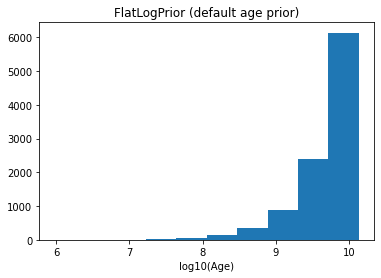

In [17]:
import matplotlib.pyplot as pl

N = 10_000
s = model._priors['age'].sample(N)
pl.hist(s)
pl.xlabel("log10(Age)")
pl.title("FlatLogPrior (default age prior)")

The prior is biased towards old ages (>1Gy). Let's change the prior to flat because some of our target may be young (<1 Gy).

# update priors

Text(0.5, 1.0, 'FlatPrior (updated prior)')

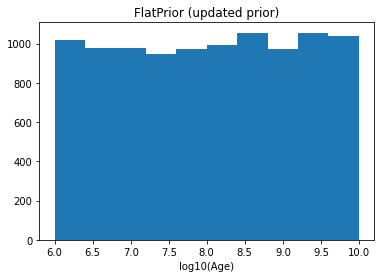

In [18]:
from isochrones.priors import FlatPrior

# change priors
model.set_prior(age=FlatPrior(bounds=(6,10)), 
              # AV=FlatPrior(bounds=(0,0.01)) #set AV=extinction=0 if target is nearby (d<10 pc)
             )
s = model._priors['age'].sample(N)
pl.hist(s);
pl.xlabel("log10(Age)")
pl.title("FlatPrior (updated prior)")

The age prior is now uniform from 10^6 (1 My) to 10^10 (10 Gy).

# get samples from updated priors

In [19]:
prior_samples = model.sample_from_prior(N)
prior_samples.head()

/ut3/uno/miniconda3/envs/isochrones/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/ut3/uno/miniconda3/envs/isochrones/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/ut3/uno/miniconda3/envs/isochrones/lib/python3.6/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_name[Fe/H]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


,age,feh,distance,AV,eep
0,7.317211,0.110574,3943.745749,0.423938,259
1,6.564044,0.063137,9576.103047,0.050697,112
2,8.699233,0.285208,8699.060445,0.787928,254
3,8.144597,0.243380,5694.892152,0.183166,297
4,7.178516,-0.204284,9291.859514,0.419058,223


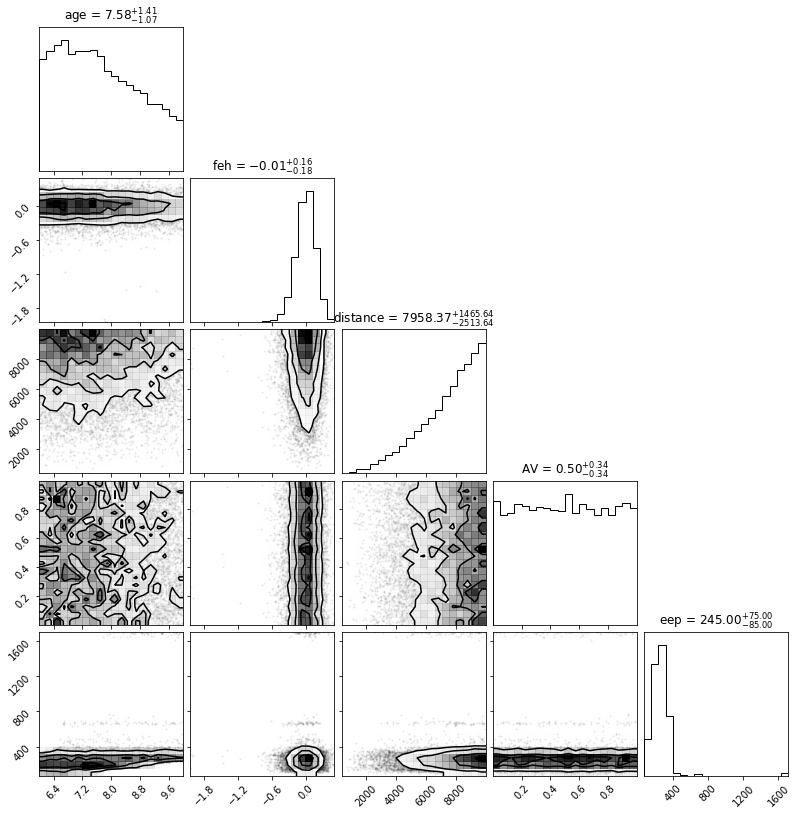

In [20]:
from corner import corner

fig = corner(prior_samples, 
             show_titles=True, 
             titles=prior_samples.columns)

* the prior distribution for age -> log10(age) is between 6 to 10 so it is fine.
* the prior distribution for feh = [Fe/H] = metallicity = iron abundance is centered around 0 = solar abunance. We don't know this for our target so it is may be a good assumption.
* the prior distribution for AV = extinction is from 0 to 1. That is fine.
* the prior distribution for EEP is between 1-400. What does it mean?

`EEP` is equivalent evolutionary phase. It is also explained in isochrones package [tutorial](https://isochrones.readthedocs.io/en/latest/modelgrids.html#Background-and-EEPs).
See [Table 2](https://waps.cfa.harvard.edu/MIST/README_tables.pdf) in MIST manual for the meaning of EEP values.
![img](../data/eep_table.png)

# fit

In [ ]:
model.fit()

In [21]:
# it creates some output in
!ls ./chains

TOI-6063-mist-single-ev.dat
TOI-6063-mist-single-IS.iterinfo
TOI-6063-mist-single-IS.points
TOI-6063-mist-single-IS.ptprob
TOI-6063-mist-single-live.points
TOI-6063-mist-single-phys_live.points
TOI-6063-mist-single-post_equal_weights.dat
TOI-6063-mist-single-resume.dat
TOI-6063-mist-single-stats.dat
TOI-6063-mist-single-summary.txt
TOI-6063-mist-single-.txt


In [22]:
# get posterior samples
cols = ['radius','mass','Teff','logg','feh','age']
posterior_samples = model.derived_samples[cols]
posterior_samples.head()

,radius,mass,Teff,logg,feh,age
0,4.809552,2.564377,7558.992497,3.482939,0.581088,8.823731
1,5.652512,2.724278,7554.659578,3.368825,0.564528,8.747393
2,5.496251,2.690144,7552.154471,3.387856,0.563041,8.762635
3,4.505544,2.505220,7550.754738,3.529546,0.577444,8.852384
4,5.445419,2.681917,7546.752488,3.394562,0.577410,8.767615


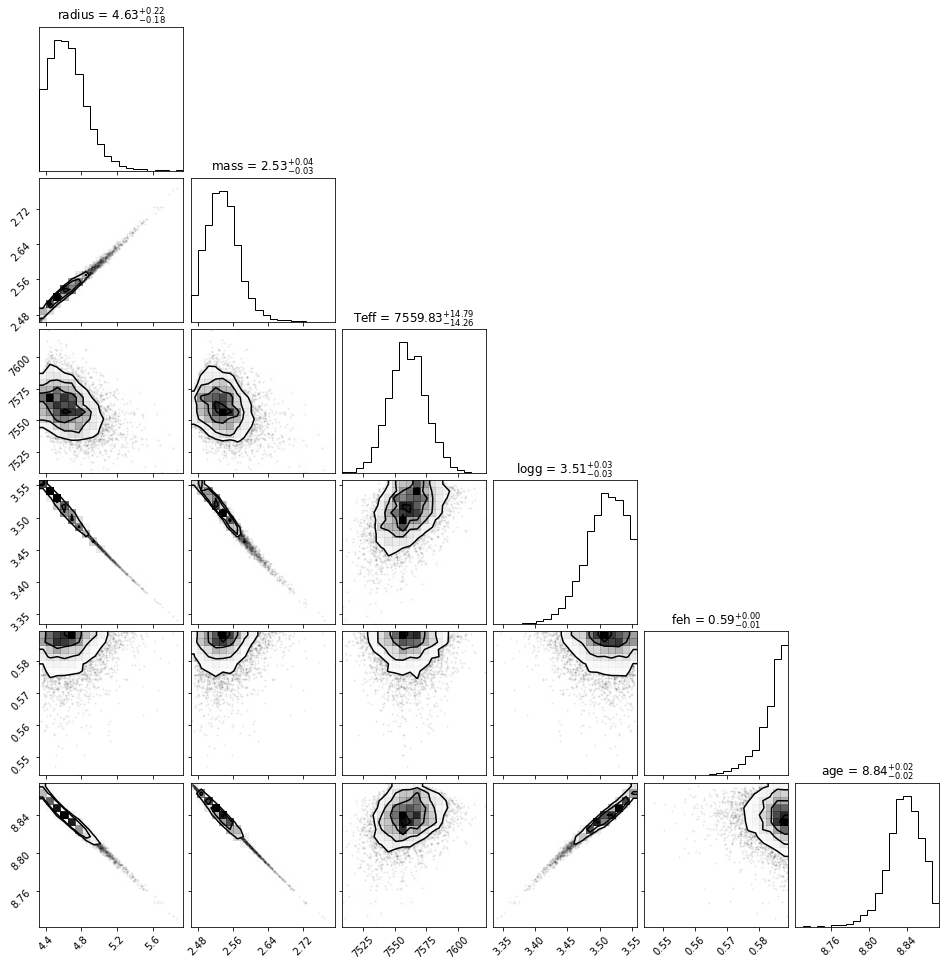

In [23]:
fig = corner(posterior_samples, 
             show_titles=True, 
             titles=posterior_samples.columns)

We want to see rounded joint posterior distributions. 
radius, mass, and Teff are rounded so they look fine but the joint distribution for feh is semi-circle.
That means the model prefers very high metallicity for this star which is almost outside of the range.

In [57]:
rad = np.median(posterior_samples['radius'])
rad_err = np.std(posterior_samples['radius'])
print(f"Rstar = {star_params['srad']}+/-{star_params['srad_e']} Rsun (exofop)")
print(f"Rstar = {rad:.2f}+/-{rad_err:.2f} Rsun (isochrones)")

Rstar = 5.54+/-None Rsun (exofop)
Rstar = 4.63+/-0.21 Rsun (isochrones)


In [58]:
mass = np.median(posterior_samples['radius'])
mass_err = np.std(posterior_samples['radius'])
print(f"Mstar = {star_params['mass']}+/-{star_params['mass_e']} Msun (exofop)")
print(f"Mstar = {rad:.2f}+/-{mass_err:.2f} Msun (isochrones)")

Mstar = +/- Msun (exofop)
Mstar = 4.63+/-0.21 Msun (isochrones)


There is no mass information from exofop.

Text(0.5, 1.0, 'Age (Myr)')

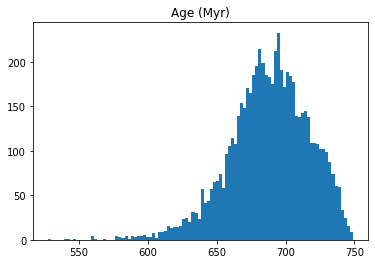

In [24]:
pl.hist(10**posterior_samples['age']/1e6, bins=100)
pl.title("Age (Myr)")

In [27]:
import numpy as np

age = np.median(10**posterior_samples['age']/1e6)
age_err = np.std(10**posterior_samples['age']/1e6)
age, age_err

(689.6755830782458, 28.90681470389361)

It looks like our example star is ~700 +/- 30 Myr!

## Binary star fit

We assumed our target star is a single star. Let us see if the input parameters is also consistent assuming there are two stars! This is important because young stars are usually confused as stars in the binary sequence in Hertzprung-Russell Diagram (HRD).

In [28]:
from isochrones import get_ichrone, BinaryStarModel

# different model but same input
model2 = BinaryStarModel(mist, 
                         name=target, 
                         **params
                        )
model2

Text(0.5, 1.0, 'FlatPrior (updated prior)')

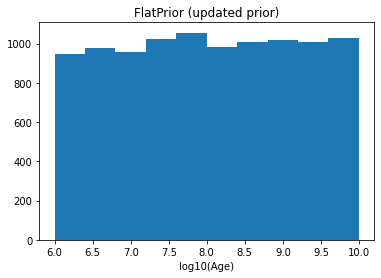

In [29]:
from isochrones.priors import FlatPrior

# again update priors
model2.set_prior(age=FlatPrior(bounds=(6,10)), 
             )
s = model2._priors['age'].sample(N)
pl.hist(s);
pl.xlabel("log10(Age)")
pl.title("FlatPrior (updated prior)")

In [30]:
#remove posterior samples for single star model
!rm -rf ./chains

In [31]:
# run fit
model2.fit()

The parameters for star 1 and star 2 are named as teff_0 and teff_1, respectively. So let's define them.

In [32]:
#star 1
cols1 = [i+'_0' for i in cols if i!='age']
#star 2
cols2 = [i+'_1' for i in cols if i!='age']

In [33]:
cols1

['radius_0', 'mass_0', 'Teff_0', 'logg_0', 'feh_0']

In [34]:
cols2

['radius_1', 'mass_1', 'Teff_1', 'logg_1', 'feh_1']

In [36]:
posterior_samples2 = model2.derived_samples

Text(0.5, 0.98, 'Star 1 (binary model)')

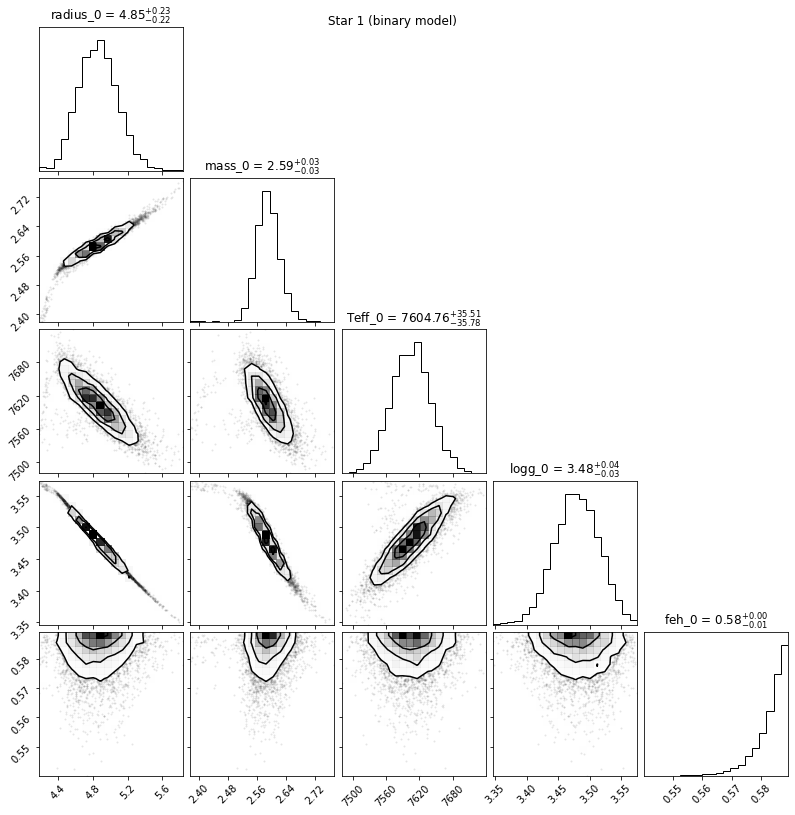

In [44]:
#star 1
fig1 = corner(posterior_samples2[cols1],
              show_titles=True, 
              titles=cols1
             )
fig1.suptitle("Star 1 (binary model)")

Text(0.5, 0.98, 'Star 2 (binary model)')

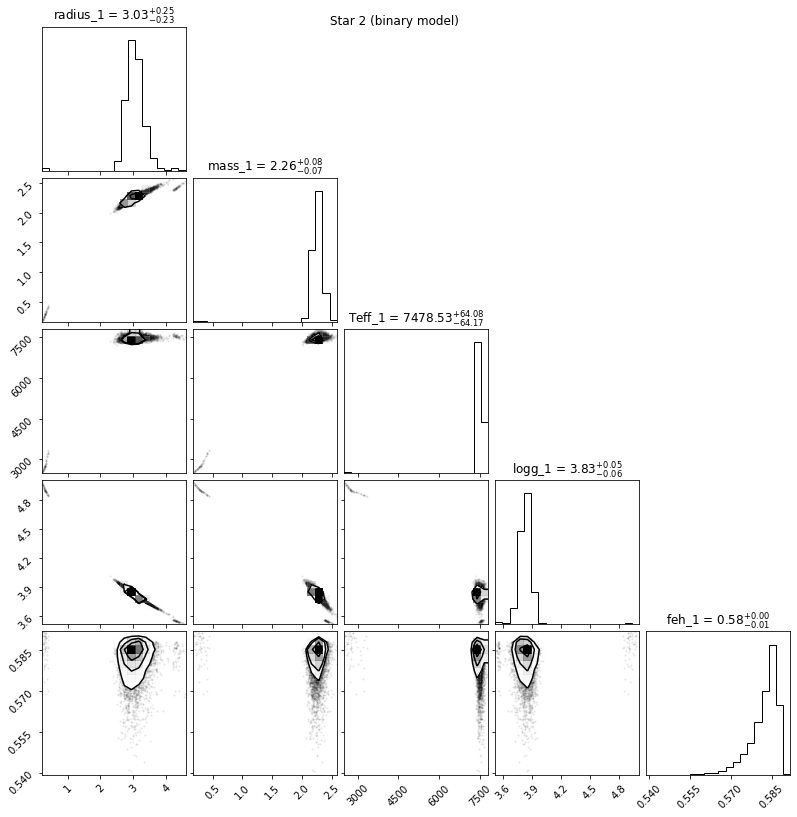

In [39]:
#star 2
fig2 = corner(posterior_samples2[cols2],
              show_titles=True, 
              titles=cols2
             )
fig2.suptitle("Star 2 (binary model)")

## combined posteriors for comparison

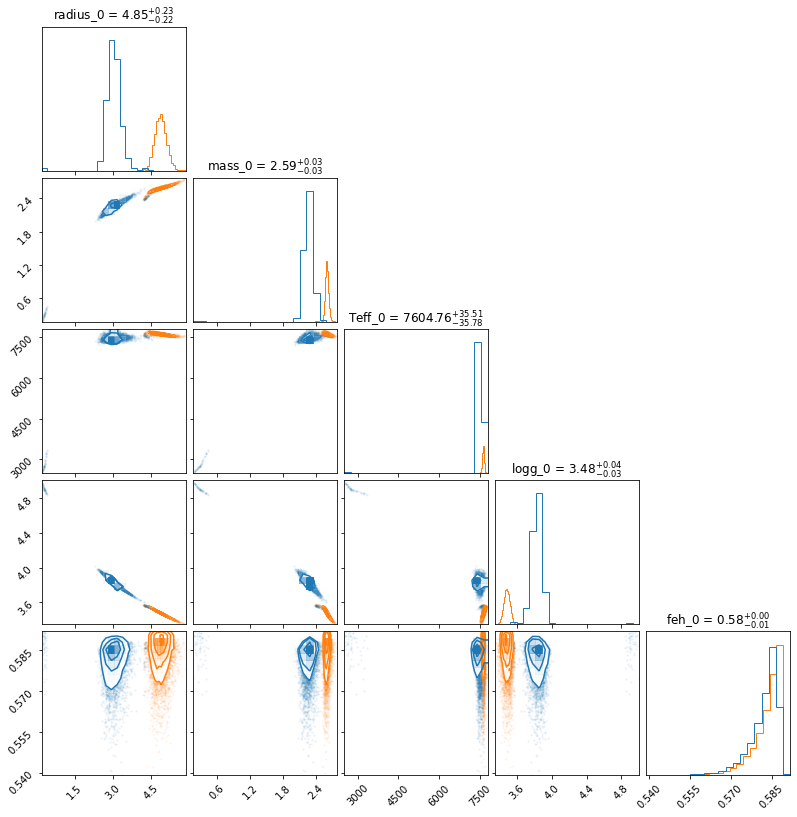

In [43]:
# star 1
fig1 = corner(posterior_samples2[cols1], 
              show_titles=True, 
              titles=cols1,
              color='C1'
             )
# star 2
_ = corner(posterior_samples2[cols2], 
           show_titles=False, 
           titles=cols2, 
           fig=fig1, #to compare
           color='C0')

This means that a binary system with parameters above is consistent with our given input data.

We can also fit assuming a triple star system which I left as an exercise.

## Exercise
* Apply isochrones to known young stars and check if you get results consistent with previous studies